# Assignment 1: Speech Production and Models 
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 28.5

In [6]:
import pickle as pkl
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
from scipy.signal import firwin, filtfilt
from scipy import signal
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy.linalg import solve_toeplitz, toeplitz
import math

In [7]:
def read_assignment_file(fname):
    with open(fname, "rb") as f:
        d = pkl.load(f)
    return d


def read_wav(fname):
    raw_data = wavfile.read(fname)
    return raw_data[1].astype(np.float32), raw_data[0]


def play_wav(x, fs):
    sd.play(x.astype(np.int16), fs)


def lowpass(x, fc, fs):
    """ x is the signal,
        fc is the cuttoff frequency expressed in Hz, must be between [0,fs/2]
    """
    b = firwin(1024, fc, fs=fs)
    y = filtfilt(b, 1, x)
    return y


def xcorr(x, y, M):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx = (lags >= -M) & (lags <= M)
    corr = corr[idx]
    lags = lags[idx]
    return lags[len(lags) // 2:], corr[len(lags) // 2:]


def get_envelop(xf, M, N, fs):
    lags, r = xcorr(xf, xf, M)

    a = np.concatenate([np.ones(1), solve_toeplitz(r[: -1], -r[1:])]).reshape(-1, 1)
    e = (a.T @ r)[0]
    w, h2 = signal.freqz(1, a, N, whole=True, fs=fs)
    X = fft(xf)
    envl = 10 * np.log10(e * np.abs(h2[0: N // 2]) ** 2)
    freq = w[0: N // 2]

    fig, ax = plt.subplots(1, 1)

    ax.plot(w[0: N // 2], 10 * np.log10(np.abs(X[0: N // 2]) ** 2), label="$X(f)$")
    ax.plot(w[0: N // 2], 10 * np.log10(e * np.abs(h2[0: N // 2]) ** 2), label="$Envelop$")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    return fig, ax, freq, envl

## Section 1: Bandwidth of Speech (2.5 pts)

In our first experiment we study how low-pass filtering affects the speech signal. Load the files male44.waw and female44.wav. The speech is sampled at 44.1 kHz.

In [8]:
male_fname = "male44.wav"
female_fname = "female44.wav"
assignment_file = "assignment1.pkl"
d = read_assignment_file(assignment_file)
xmale, fs = read_wav(male_fname)
xfemale, fs = read_wav(female_fname)

### Question 1.1 (0.5 pts)


This is a test of intelligibility, i.e., how well we can understand what is spoken.

At what cut-off frequency do you start hearing what is said?

In [9]:
# Inteligibility
play_wav(lowpass(xmale, 1800, fs), fs)

In [10]:
play_wav(lowpass(xfemale, 2000, fs), fs)

##### Answer:
We start hearing what is said at cut-off frequency 1800 Hz for male, 2000 Hz for female.

### Question 1.2 (0.5 pts)

At what cut-off frequency do you start to hear a degradation in overall speech quality?

In [11]:
# Degradation
play_wav(lowpass(xmale, 2300, fs), fs)

In [12]:
play_wav(lowpass(xfemale, 2800, fs), fs)

##### Answer:
We start hearing a degradation at cut-off frequency 2300 Hz for male, 2800 Hz for female.

### Question 1.3 (1 pts)

Why, do you think (you are allowed to speculate!), is a sampling frequency of 8 kHz used in plain old telephony services (POTS)? 

##### Answer:
Because human speech is almost perfectly recognizable at the frequency of 4 kHz. 8 kHz is larger than twice of the degradation threshold of male or female voice. With this sampling frequency, the voice of the speaker can be transferred without degradation.

## Section 2: Voiced and Unvoiced Speech Sounds (8 pts)

From a time plot, find voiced and unvoiced regions. Study the harmonic structure and envelope of the speech spectra corresponding to voiced and
unvoiced regions.

### Question 2.1 (0.5 pts)

Create a time plot with voiced and unvoiced regions marked.

##### Answer:
<img src="./2-1.png" alt="alt text" width="400"/>

### Question 2.2 (0.5 pts)

In the time plot, mark the regions where the pitch is the highest and the lowest. What are the pitch frequencies in those regions?

##### Answer:
<img src="./2-2.png" alt="alt text" width="400"/>


### Question 2.3 (0.5 pts)

Plot the DFT based spectrum for a voiced frame.

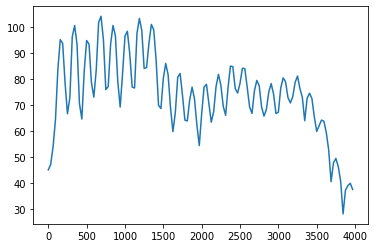

In [13]:
S = 1000  # Start of the frame
N = 256  # Length of the frame
fs = 8000
x = d['male_short']
x = x.flatten()
df = fs / N
ff = np.arange(0, fs // 2, df)

xf = x[S - 1: S + N - 1] * signal.windows.hann(N)
X = fft(xf)
plt.plot(ff, 10 * np.log10(np.abs(X[0: N // 2]) ** 2))
plt.show()

### Question 2.4 (1 pts)

What is the mathematical expression of element `X[3]`, i.e.,
the third element in the FFT vector? What analog frequency (between
0-8000 Hz) does `X[3]` correspond to?


##### Answer:
$X[3] = \sum_{n=0}^{N-1}x[n]e^{-3j\frac{2\pi}{N}n}$

Corresponding analog frequency:

$(3-1) \times \frac{f_s}{N} = (3-1) \times \frac{8000}{256} = 62.5\  \rm Hz$

### Question 2.5 (0.5 pts)

What is the fundamental frequency (pitch) in your particular case?

In [14]:
v = 10 * np.log10(np.abs(X[0: N // 2]) ** 2)
peaks, _ = signal.find_peaks(v, 5)
idx = 0

for j in range(len(peaks)):

    if v[peaks[j]] > v[peaks[idx]]:
        idx = j

print(idx, ff[peaks[idx]])

3 687.5


##### Answer:
The fundamental frequency is 687.5 Hz.

### Question 2.6 (1 pts)

What frame length is appropriate? What compromise do you have to
make when choosing frame length?

##### Answer:
The appropriate frame length is $N = 256$, $\frac{N}{f_s} = \frac{256}{8000} = 32 \rm ms$. Given

    Frequency Resolution = Fundemental Frequency / N,

a smaller frame length will result in a higher frequency resolution. However, we cannot make full use of the statistic characteristics of the signal in this case since only a small part of the signal is considered. An extreme opposite case is that the entire signal is processed within one long single frame.

### Question 2.7 (1 pts)

Replace the hanning window function with a rectangular window and compare the result.

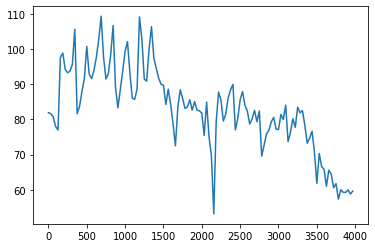

In [15]:
xf_rect = x[S - 1: S + N - 1] * signal.windows.boxcar(N)
X_rect = fft(xf_rect)

plt.plot(ff, 10 * np.log10(np.abs(X_rect[0: N // 2]) ** 2))
plt.show()

##### Answer:
We can see that the application of the rectangular window results in a relatively higher frequency resolution and larger fluctuations.

### Question 2.8 (0.5 pts)

Extend the code above to plot also the LP envelope of the short-time speech spectrum.

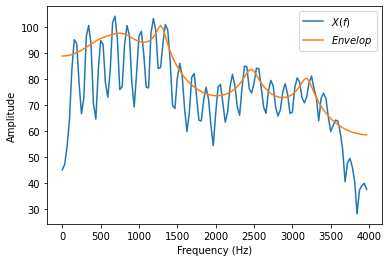

In [16]:
# M is the prediction order
M = 10
fig, ax, freq, envl = get_envelop(xf, M, N, fs)
plt.show()

### Question 2.9 (1 pts)

What is the mathematical expression of element `c(3)` (`corr(3)` in the `xcorr` function)? Why do we multiply `abs(h[1:N//2+1])**2` by `e` before plotting?

##### Answer:
$c(3) = \frac{1}{N}\sum_{n=0}^{N-3}x(n+3)x(n) \\ R_Y(f) = |H(f)|^2R_X(f) = |H(f)|^2\sigma ^2$

The process can be modeled as an AR process with white noise as input. `e` is the power, i.e., the variance of the white noise.

### Question 2.10 (1 pts)

What prediction order do you recommend? 

##### Answer:
M = 10. Vowels usually have four formants, consistent with the 4 peaks as we can observe in the PSD. Therefore, the order of the AR process should be 8. Here, we choose a slightly larger order to be more precise.

### Question 2.11 (0.5 pts)

Repeat the spectrum plotting for an unvoiced frame.

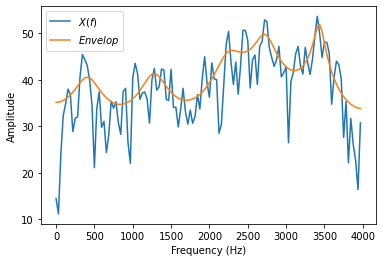

In [17]:
S_unvoiced = 7200  # Start of the frame
xf_unvoiced = x[S_unvoiced - 1: S_unvoiced + N - 1] * signal.windows.hann(N)
X_unvoiced = fft(xf_unvoiced)

M = 10
fig_unvoiced, ax_unvoiced, freq_unvoiced, envl_unvoiced = get_envelop(xf_unvoiced, M, N, fs)
plt.show()

## Section 3: Formants (2.5 pts)

In the speech variable “male short”, try to identify the vowels by comparing
the formants from an LP analysis to the formant frequencies of template vowels
in Table 1. Note that the table contains only the three first formants; you can
often see up to four formants.


vowel|F1|F2|F3|example

iy|270|2290|3010|beet

ih|390|1990|2550|bit

eh|530|1840|2480|bet

ae|660|1720|2410|bat

ah|520|1190|2390|but

aa|730|1090|2240|hot

ao|570|840|2410|bought

uh|440|1020|2240|foot

uw|300|870|2240|boot

er|490|1350|1690|bird

### Question 3.1 (1 pts)

In the plot from the previous section, add the formant frequencies
and the vowels you come up with.

750.0
1281.2499999999998
2468.75
3187.4999999999995


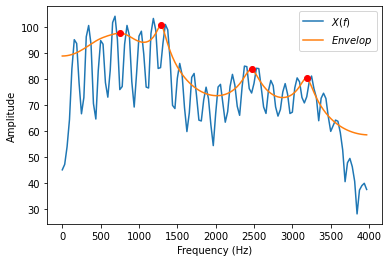

In [18]:
fig, ax, freq, envl = get_envelop(xf, M, N, fs)

peaks, _ = signal.find_peaks(envl, 10)
fpeak = np.zeros(peaks.size)

for i in range(peaks.size):

    ax.plot(freq[peaks[i]], envl[peaks[i]], color='r', marker='o')
    print(freq[peaks[i]])

plt.show()

##### Answer:
We can see that F1 = 750 Hz, F2 = 1280 Hz, F3 = 2470 Hz. The vowel is closest to "aa"(730|1090|2240).

### Question 3.2 (1.5 pts)

How are pitch and formant frequencies related?

##### Answer:
Pitch is the fundamental frequency of vibration of the vocal folds. They vibrate quasi-periodically only for voiced phonemes. For unvoiced sounds, there is nothing called pitch.

The formant frequencies are due to the frequency shaping of the signal from the vocal folds by the vocal tract. Each formant corresponds to a resonance in the vocal tract. Formants exist for both voiced and unvoiced sounds.[1]

## Section 4: Phonemes and Allophones (2.5 pts)

Vowels, which we studied in the previous section, constitute one class of phonemes.
Here we identify what other phonemes are contained in “male short”.

### Question 4.1 (1 pts)

In the time plot from the previous sections, mark the regions of the other phonemes and label each region with the correct phonetic symbol.

In [19]:
play_wav(x, fs)

##### Answer:
<img src="./4-1.png" alt="alt text" width="400"/>

### Question 4.2 (1 pts)

Can consonants have formant frequencies?

##### Answer:
Consonants can have formant frequencies. Voiced consonants such as nasals and laterals have specific vocal tract shapes that are characterized by the frequencies of the formants. Other consonants such as stops and approximants (semivowels) can also be characterized in part by the formants of their vocal tract shapes.[2]

### Question 4.3 (0.5 pts)

What is a diphthong?

##### Answer:
A diphthong is a sound formed by the combination of two vowels in a single syllable, in which the sound begins as one vowel and moves towards another(as in coin, loud, and side).[3]

### Question 4.4 (0.5 pts)

How many phonemes are there in English?

##### Answer:
44.

### Question 4.5 (0.5 pts)

What is a phone? What is an allophone? How many allophones are there?

##### Answer:
The term phone is used when a speech sound is considered separate from language. A phone is a unit of speech sound, which may refer to any speech sound or gesture without regard of its place in phonology of a language.

Allophones are phonetic variations of a phenome that do not change spoken word meaning. For example, the aspirated "p" in "pot" and the unaspirated "p" in "spot" are allophones of /p/.

There are two types of allophones, based on whether a phoneme must be pronounced using a specific allophone in a specific situation or whether the speaker has the unconscious freedom to choose the allophone that is used. Therefore, there’s not an exact number of allophones.[4]

##### References:
[1] https://www.researchgate.net/post/What_is_the_difference_between_pitch_and_formant_frequency

[2] https://www.britannica.com/science/phonetics/Vowel-formants

[3] Definitions from Oxford Languages

[4] https://en.wikipedia.org/wiki/Allophone

## Section 5: The Spectrogram (3 pts)

Program a spectrogram function in Python. A spectrogram shows the energy in speech as a function of time and frequency. The result is often displayed with time on the horizontal axis, and frequency on the vertical
axis. The energy (squared magnitude, and in dB) of the DFT coefficients are illustrated by e.g. a grayscale, where black corresponds to high energy, and white represents low energy. To obtain a smooth evolution over time,
we want to use overlapping analysis windows, see Figure 1. 
Test your function on the speech samples provided for this lab. For the presentation have the result for “male short” available.

<img src="./windowing.png" alt="alt text" width="400"/>

### Question 5.1 (0.5 pts)

First program a function that extracts overlapping frames and plots each frame. 
Input arguments should be update length, and analysis length.

Call `myspectrogram(x_short, 256, 32)` and view the animation. 

In [20]:
%matplotlib auto
def myspectrogram_t(x, alen, ulen):
    """ x is the speech vector,
    alen is the analysis frame length,
    ulen is the update length"""
    N = len(x)
    fs = 8000
    naf = np.floor((N - alen + ulen) / ulen)
    naf = int(naf)
    n1 = 1
    n2 = alen

    alen_2 = int(alen / 2)
    t = np.linspace(0, N - 1, N) / fs

    # plt.ion()

    f, ax1 = plt.subplots(1, 1)

    for n in range(0, naf):
        
        xf = x[n1 - 1: n2]
        tf = t[n1 - 1: n2]

        ax1.cla()

        ax1.plot(tf, xf)
        ax1.set_xlabel('Time/s')
        ax1.set_ylabel('Magnitude')

        plt.pause(0.05)

        n1 = n1 + ulen
        n2 = n2 + ulen

    # plt.ioff()
    # plt.show()

    return

Using matplotlib backend: <object object at 0x0000027A860BE150>


In [ ]:
x = d['male_short']
x = x.flatten()
myspectrogram_t(x, 256, 32)

### Question 5.2 (0.5 pts)

Next add frequency analysis of each frame. Use the code for the DFT based spectrum from section 2 (dont forget to window before DFT). If you want to plot both the time domain signal, and the spectrum in the same plot, but in different parts of the window, see subplot. Illustrate the function as in the previous step.

In [21]:
def myspectrogram(x, alen, ulen):
    """ x is the speech vector,
    alen is the analysis frame length,
    ulen is the update length"""
    N = len(x)
    fs = 8000
    naf = np.floor((N - alen + ulen) / ulen)
    naf = int(naf)
    n1 = 1
    n2 = alen
    fs_2 = int(fs / 2)
    alen_2 = int(alen / 2)
    t = np.linspace(0, N - 1, N) / fs
    ff = np.linspace(0, fs_2, alen_2)

    # plt.ion()

    f, (ax1, ax2) = plt.subplots(2, 1)

    for n in range(0, naf):
        
        xf = x[n1 - 1: n2]
        tf = t[n1 - 1: n2]
        xf2 = xf * signal.windows.hann(alen)
        X = fft(xf2)

        ax1.cla()
        ax2.cla()

        ax1.plot(tf, xf)
        ax1.set_xlabel('Time/s')
        ax1.set_ylabel('Magnitude')

        ax2.plot(ff, 10 * np.log10(np.abs(X[0: alen // 2]) ** 2))
        ax2.set_xlabel('Frequency/Hz')
        ax2.set_ylabel('Amplitude/dB')

        plt.pause(0.05)

        n1 = n1 + ulen
        n2 = n2 + ulen

    # plt.ioff()
    # plt.show()

    return

In [ ]:
myspectrogram(x, 256, 32)

### Question 5.3 (1 pts)

Implement the classical spectrogram.

In [22]:
%matplotlib inline
def clsc_spectrogram(x, alen, ulen):
    """ x is the speech vector, 
    alen is the analysis frame length, 
    ulen is the update length"""
    N = len(x)
    fs = 8000
    naf = np.floor((N - alen + ulen) / ulen)
    naf = int(naf)
    n1 = 1
    n2 = alen
    alen_2 = int(alen / 2)

    S = np.zeros((alen_2, naf))

    for n in range(0, naf):
        
        xf = x[n1 - 1: n2]
        xf2 = xf * signal.windows.hann(alen)

        if alen > ulen:

            X = fft(xf2)

        else:

            X = fft(xf2, 2 * alen)

        S[:, n] = 10 * np.log10(np.abs(X[0: alen // 2]) ** 2)

        n1 = n1 + ulen
        n2 = n2 + ulen

    plt.imshow(-S, aspect="auto", cmap="gray", origin="lower")
    # plt.imshow(np.flipud(-S), aspect = "equal", cmap = "gray")
    plt.xlabel('Time/s')
    plt.ylabel('Frequency/Hz')

    dx = (N - 1) / fs
    x_location = [0, naf / dx * 0.1, naf / dx * 0.2, naf / dx * 0.3, naf / dx * 0.4, naf / dx * 0.5, naf / dx * 0.6,
                  naf / dx * 0.7, naf / dx * 0.8, naf / dx * 0.9]
    x_label = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    plt.xticks(x_location, x_label)

    y_location = np.arange(0, int(alen_2 / 8 * 9), alen_2 / 8)
    y_label = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    plt.yticks(y_location, y_label)

    return

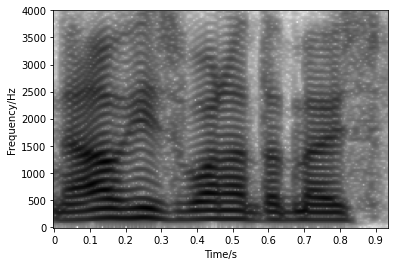

In [23]:
clsc_spectrogram(x, 256, 32)

### Question 5.4 (0.5 pts)

Produce a narrow-band spectrogram. Be prepared to indicate the fundamental frequency track, and the boundaries of the phonemes.

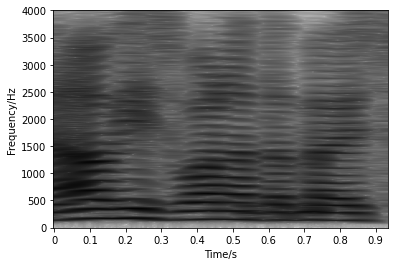

In [24]:
clsc_spectrogram(x, 1024, 32)

### Question 5.5 (0.5 pts)

Produce a wide-band spectrogram. Here the spectrogram tends to become blocky if smoothing is not performed in the frequency domain. Incorporate smoothing by zero-padding before applying the DFT. Can you see the formant trajectories?

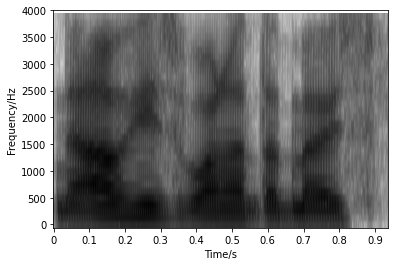

In [25]:
clsc_spectrogram(x, 64, 4)

## Section 6: Speech Parameter Estimation (5 pts)

In this section, you will analyze (estimate) the parameters of a vocoder model. In the next section you will synthesize speech based on the estimated parameters. The parameters we will estimate are frame energy, pitch, vocal tract filter coefficients, and voiced/unvoiced classification. The estimation should be done on a frame-by-frame basis and we will use overlapping analysis frames. Just as in the case of the spectrogram the choice of analysis frame length is a compromise between having long enough frames to get reliable estimates, but not too long so that rapid events are averaged out 2. Also as in the spectrogram case, the update length controls the smoothness of
the parameter trajectories over time.

### Question 6.1 (0.5 pts)

Let us warm up with estimation of frame energy (normalized per sample)

$E = \frac{1}{N_\alpha}\sum_{n=0}^{N_\alpha-1}x^2(n)$

where $N_\alpha$ is the analysis frame length and the sum is over the samples in one analysis frame. Write a function that returns the frame energies in a vector. Start with the function skeleton from the first task in section 5. Before the loop over all frames, allocate space for the vector of energies.

### Question 6.2 (1 pts)

Next let us look at voiced/unvoiced detection. This is a difficult problem, but here we resolve to a simple solution based on zero-crossings. A zero crossing occurs when $x(n)x(n − 1) < 0$. By counting all those occurrences within a frame, and normalizing by the frame length, a (near) continuous parameter is obtained. To make a binary decision a threshold can be used (by normalizing with the frame length, the threshold becomes independent (almost) of the analysis frame length). Extend your analysis function.

### Question 6.3 (0.5 pts)

Next extend your analysis function by incorporating code for vocal tract filter estimation via LP analysis. The code from Section 2 should work fine! Store the filter parameters in the rows of a matrix.

### Question 6.4 (0.5 pts)

Finally extend the function with pitch analysis. Many speech coding (compression) systems depend on accurate pitch analysis. Here we base our estimation on the correlation function of the frame. You may choose if you wish to use the ACF or the normalized cross-correlation function (slightly more difficult to program). The problem you have to solve is how to find the lag of the peak in the ACF that corresponds to one pitch period. This is usually easy to do “manually”, i.e., by looking at the ACF, but you have to make the computer do it automatically!

In [26]:
def analysis_E_ZC_V_A_P(x, alen, ulen, M):
    N = len(x)
    naf = np.floor((N - alen + ulen) / ulen)
    naf = int(naf)
    n1 = 1
    n2 = alen

    # Initialization
    E = np.zeros(naf)           # Frame Energy
    ZC = np.zeros(naf)          # Zero Crossings
    V = np.zeros(naf)           # Voiced / Unvoiced
    A = np.zeros((naf, M + 1))  # LP Coefficients, M: Prediction Order
    P = np.zeros(naf)           # Pitch Period

    for n in range(0, naf):

        xf0 = x[n1 - 1: n2]
        xf = np.int64(xf0)
        e = np.power(xf, 2)
        E[n] = np.sum(e) / alen

        count_zc = 0            # number of zero crossings

        for i in range(1, alen):

            if xf[i - 1] * xf[i] < 0:
                count_zc = count_zc + 1

        ZC[n] = count_zc / alen

        if ZC[n] < 0.28:

            V[n] = 1  # Voiced

        else:

            V[n] = 0  # Unvoiced

        _, r = xcorr(xf, xf, M)
        a = np.concatenate([np.ones(1), solve_toeplitz(r[: -1], -r[1:])]).reshape(-1, 1)
        A[n] = a.T

        corr = signal.correlate(xf, xf, mode='full')
        corr = corr[(len(corr) + 1) // 2 - 1:]
        peaks, _ = signal.find_peaks(corr, 3)
        idx = 0

        for j in range(len(peaks)):

            if corr[peaks[j]] > corr[peaks[idx]]:
                idx = j

        P[n] = peaks[idx]

        n1 = n1 + ulen
        n2 = n2 + ulen

    return E, ZC, V, A, P

### Question 6.5 (0.5 pts)

Plot the output of your analysis function with the following code (or include the code below in the analysis function). Test and tune your analysis function on the files “male_long”, and “female_long”. Be prepared to provide plots with smooth temporal evolution, i.e., with ulen = 1.

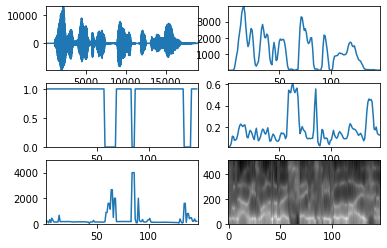

In [27]:
x = d['male_long']
# x = d['female_long']
x = x.flatten()
alen = 256
ulen = 128
N = len(x)
naf = np.floor((N - alen + ulen) / ulen)
naf = int(naf)
M = 10
E, ZC, V, A, P = analysis_E_ZC_V_A_P(x, alen, ulen, M)

plt.figure()

plt.subplot(3, 2, 1)
plt.plot(x)             # Plot the input waveform
plt.axis([1, len(x), np.min(x), np.max(x)])

plt.subplot(3, 2, 2)
plt.plot(np.sqrt(E))    # Plot the standard deviation
plt.axis([1, len(E), np.min(np.sqrt(E)), np.max(np.sqrt(E))])

plt.subplot(3, 2, 3)
plt.plot(V)             # Plot voiced/unvoiced decision
plt.axis([1, len(V), 0, 1.1])

plt.subplot(3, 2, 4)
plt.plot(ZC)            # Plot the normalized number of zero-crossings
plt.axis([1, len(ZC), np.min(ZC), np.max(ZC)])

plt.subplot(3, 2, 5)
F = 8000 / P
plt.plot(F)             # Plot the fundamental frequency in Hz
plt.axis([1, len(F), 0, 5000])

plt.subplot(3, 2, 6)    # Plot the classical spectrogram
S = np.zeros((512, naf))
for n in range(0, naf):
    _, b = signal.freqz(1, A[n], 512)
    S[:, n] = 20 * np.log10(np.abs(b))

plt.imshow(S, aspect="auto", cmap="gray", origin="lower")
# plt.imshow(np.flipud(S), aspect = "auto", cmap="gray")

### Question 6.6 (1 pts)

What could make the voiced/unvoiced detection go wrong? 

##### Answer:
The voiced/unvoiced detection could go wrong if the sound is not clear enough. Besides, an inappropriate threshold selection can lead to detection errors. Especially, detection at the transition between voiced and unvoiced regions is prone to errors.

### Question 6.7 (1 pts)

In the pitch estimation, what can cause pitch doubling? What can be the reason for pitch halving?

##### Answer:
If the power of a harmonic is high, the harmonic frequency could be interpreted as the fundamental frequency. When it is outside the true fundamental frequency, there is "pitch doubling". When it is interpolated between zero frequency and the true fundamental frequency, "pitch halving" occurs.

## Section 7: Vocoder (5 pts)

In this section we will synthesize speech based on the parameters from the analysis. Speech coding (compression) systems based on this principle are called vocoders and can reach bit rates as low as 2 kbits/second when the parameters are quantized. This can be compared with 64 kbits/second for the PCM system used in fixed telephone networks. The quality of the vocoder is lower though. Here we will synthesize speech based on unquantized parameters.

### Question 7.1 (1 pts)

Let us start by only incorporating the vocal tract filter in the synthesis.
Make sure you use the same update length (ulen) in the synthesis as in the analysis! Make sure you understand why ulen samples are generated in the synthesis for each analysis frame.
Test with a pulse train excitation (use a constant pitch corresponding to 100 Hz). Then test with noise excitation. Can you hear what is said based on only vocal tract parameters (you may need to rescale the whole output before playing back)?


Note:
Instead of varifilter you can also use the Python function `lfiltic` to implement the synthesis. But then you have to make sure that the final filter state after one frame is used as initial state in the next frame. The simple `filtfilt` function in Python is not designed for time-varying coefficients and audible clicks may result. To remedy this, see the function filtic, and varifilter. Another option is to implement the filter yourself. In that way you have full control over the filter memory. The downside is that your filter will probably execute slower than Python’s filter which is a built-in function.

In [28]:
def synthesis1(E, ZC, V, A, P, ulen):
    # We have included all the estimated parameters as input arguments but here we only use A!

    A = np.float32(A)
    n_frames = A.shape[0]

    # Create a pulse train excitation:
    cp = 80  # Constant pitch period in samples
    pexc = np.zeros(n_frames * ulen)
    pexc = np.float32(pexc)
    pexc[0:: cp] = 1

    # Create a noise excitation:
    # nexc = np.random.rand(n_frames * ulen)
    # nexc = np.float32(nexc)

    n1 = 0
    Z = np.array([])
    Z = np.float32(Z)
    
    s = np.zeros(n_frames * ulen)
    s = np.float32(s)

    for n in range(0, n_frames):
        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter

        if Z.shape[0] == 0:

            s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen])
            Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=pexc[n1: n1 + ulen])

        else:

            s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen], zi=Z)

        n1 = n1 + ulen

    return s

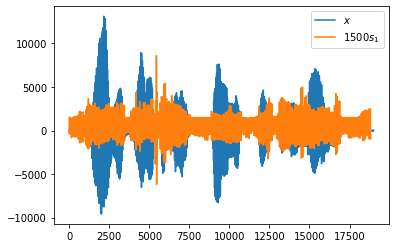

In [29]:
s1 = synthesis1(E, ZC, V, A, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(1500 * s1, label="$1500s_1$")
ax.legend()

In [30]:
sd.play(s1, 8000)

### Question 7.2 (1 pts)

 Make sure the energy contour of the synthesized speech matches that of the original speech. A crude but simple way is to (re)normalize each synthesized frame to have frame energy $E(n)$.

Write a new function `synthesis2` (naturally based on `synthesis1`). Test with the pulse and noise excitations from the previous task. How much does the energy contour contribute to the intelligibility?

Note: In the most straightforward energy normalization, a problem occurs when the synthesis frame contains no pitch pulses (this will happen frequently if your update length is short). Can you suggest a fix? It may require estimating the prediction residual energy (thus changing also your analysis function slightly), and re-normalizing the excitation (before filtering) during synthesis.

In [31]:
def synthesis2(E, ZC, V, A, P, ulen):
    # We have included all the estimated parameters as input arguments but here we only use A!

    A = np.float32(A)
    n_frames = A.shape[0]

    # Create a pulse train excitation:
    cp = 80  # Constant pitch period in samples
    pexc = np.zeros(n_frames * ulen)
    pexc = np.float32(pexc)
    pexc[0:: cp] = 1

    # Create a noise excitation:
    nexc = np.random.rand(n_frames * ulen)
    nexc = np.float32(nexc)
    
    n1 = 0
    Z = np.array([])
    Z = np.float32(Z)
    
    s = np.zeros(n_frames * ulen)
    s = np.float32(s)

    E2 = np.zeros(n_frames)
    E2 = np.float32(E2)

    for n in range(0, n_frames):

        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter
        if Z.shape[0] == 0:

            s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen])
            Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=pexc[n1: n1 + ulen])

        else:

            s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen], zi=Z)

        e = np.power(s[n1: n1 + ulen], 2)
        E2[n] = np.sum(e) / ulen
        s[n1: n1 + ulen] = s[n1: n1 + ulen] * math.sqrt(E[n] / E2[n])
        n1 = n1 + ulen

    return s

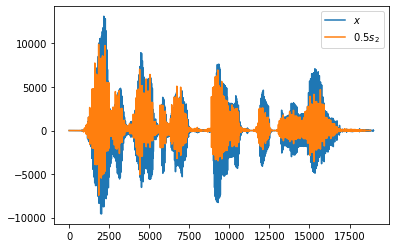

In [32]:
s2 = synthesis2(E, ZC, V, A, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(0.5 * s2, label="$0.5s_2$")
ax.legend()

In [33]:
sd.play(s2, 8000)

### Question 7.3 (0.5 pts)

Switch between pulse excitation and noise excitation based on the voiced/unvoiced decision, and write `synthesis3`. Does this increase intelligibility? Our vocoder model assumes that all speech sounds are either voiced or unvoiced. Is this true? Discuss how our vocoder could be modified?


In [34]:
def synthesis3(E, ZC, V, A, P, ulen):
    # We have included all the estimated parameters as input arguments but here we only use A!

    A = np.float32(A)
    n_frames = A.shape[0]

    # Create a pulse train excitation:
    cp = 80  # Constant pitch period in samples
    pexc = np.zeros(n_frames * ulen)
    pexc = np.float32(pexc)
    pexc[0:: cp] = 1

    # Create a noise excitation:
    nexc = np.random.rand(n_frames * ulen)
    nexc = np.float32(nexc)

    n1 = 0
    Z = np.array([])
    Z = np.float32(Z)
    
    s = np.zeros(n_frames * ulen)
    s = np.float32(s)

    E2 = np.zeros(n_frames)
    E2 = np.float32(E2)

    for n in range(0, n_frames):

        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter
        if V[n] == 1:

            if Z.shape[0] == 0:

                s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen])
                Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=pexc[n1: n1 + ulen])

            else:

                s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen], zi=Z)

        else:

            if Z.shape[0] == 0:

                s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], nexc[n1: n1 + ulen])
                Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=nexc[n1: n1 + ulen])

            else:

                s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], nexc[n1: n1 + ulen], zi=Z)

        e = np.power(s[n1: n1 + ulen], 2)
        E2[n] = np.sum(e) / ulen
        s[n1: n1 + ulen] = s[n1: n1 + ulen] * math.sqrt(E[n] / E2[n])
        n1 = n1 + ulen

    return s

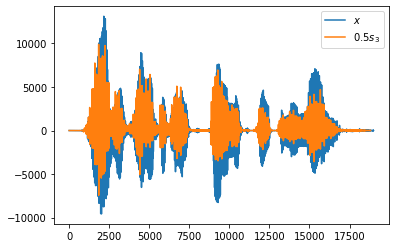

In [35]:
s3 = synthesis3(E, ZC, V, A, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(0.5 * s3, label="$0.5s_3$")
ax.legend()

In [36]:
sd.play(s3, 8000)

### Question 7.4 (1 pts)

 Create a function `synthesis4` by adding time varying pitch! Now you cannot use the variable pexc anymore, but have to create the pulse train "on the fly".
One way is to keep a counter that is incremented for each sample during voiced frames.
When the counter equals or exceeds the current pitch value, a pulse is inserted into the excitation, and the counter is set to zero. The quality of the synthesized speech depends a lot on the quality of the pitch estimate.
Make sure the pitch contour is smooth in voiced regions.
If necessary you may median filter the pitch contour prior to synthesis.

In [37]:
def synthesis4(E, ZC, V, A, P, ulen):
    
    A = np.float32(A)
    n_frames = A.shape[0]

    # Create a noise excitation:
    nexc = np.random.rand(n_frames * ulen)
    nexc = np.float32(nexc)

    n1 = 0
    Z = np.array([])
    Z = np.float32(Z)

    s = np.zeros(n_frames * ulen)
    s = np.float32(s)

    E2 = np.zeros(n_frames)
    E2 = np.float32(E2)

    idx = 0

    for n in range(0, n_frames):

        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter
        if V[n] == 1:

            while idx < P[n]:
                idx = idx + 1

            cp = P[n]
            cp = int(cp)
            pexc = np.zeros(n_frames * ulen)
            pexc = np.float32(pexc)
            pexc[0:: cp] = 1

            if Z.shape[0] == 0:

                s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen])
                Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=pexc[n1: n1 + ulen])

            else:

                s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen], zi=Z)

        else:

            if Z.shape[0] == 0:

                s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], nexc[n1: n1 + ulen])
                Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=nexc[n1: n1 + ulen])

            else:
                
                s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], nexc[n1: n1 + ulen], zi=Z)

        e = np.power(s[n1: n1 + ulen], 2)
        E2[n] = np.sum(e) / ulen
        s[n1: n1 + ulen] = s[n1: n1 + ulen] * math.sqrt(E[n] / E2[n])
        n1 = n1 + ulen
        idx = 0

    return s

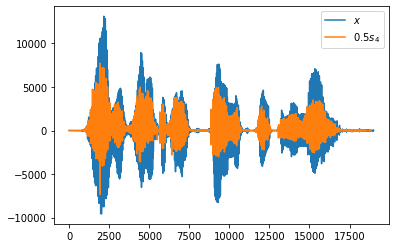

In [38]:
s4 = synthesis4(E, ZC, V, A, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(0.5 * s4, label="$0.5s_4$")
ax.legend()

In [39]:
sd.play(s4, 8000)

### Question 7.5 (1.5 pts)

Tune your analysis and synthesis functions so that the produced speech has as high quality as possible. We want to hear an exciting result! Please
make sure the vocoder output is readily available in a separate file when you come to present your results. 
